In [1]:
from PIL import Image
import numpy as np
import cv2
import torch
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm

import autoregressive_model

Load data and train the model

In [15]:
model = autoregressive_model.AutoRegressiveModel(3, 6, 512, 3, num_buckets = 20, ac_low = np.array([-3, -2, -1, -3, -2, -1]), ac_high = np.array([3, 2, 1, 3, 2, 1])).cuda()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
buffer_states = np.load("Buffer.npz")["states"]
traj_lengths = np.array([np.argmax([(np.zeros(9) == buffer_states[i,j]).all() for j in range(buffer_states.shape[1])] + [True]) for i in range(buffer_states.shape[0])])
length_between_samples = 50

In [17]:
buffer_states_new = []

def encode(s):
    num_buckets = 20
    ac_low = model.ac_low.cpu().numpy()
    ac_high = model.ac_high.cpu().numpy()
    bucket_size = (ac_high - ac_low)/num_buckets
    bucket_idx = (s[:3] - ac_low[:3]) // (bucket_size[:3] + 1e-9)
    bucket_idx = np.clip(bucket_idx, 0, num_buckets - 1)
#     print(bucket_idx)
    return "$".join([str(int(x)) for x in bucket_idx])

for j, traj in enumerate(buffer_states):
#     print(j, "of", len(buffer_states))
    skip = True
    for s in traj:
#         print(s)
        if encode(s[:3]) == encode(np.array([2, -1, 0])):
#             print("In here")
            skip = False
            break
    if not skip:
        print(j)
        buffer_states_new.append(traj)

buffer_states = buffer_states[0:1000]
buffer_states = list(buffer_states) + buffer_states_new
buffer_states = np.asarray(buffer_states)

2
2178
2285
2600
2651
2941
3011
3021


In [18]:
def sample_visited_batch(batch_size, max_diff):
    """
    Retruns pairs of observations that are at most max_diff timesteps appart
    """

    traj_idxs = np.random.choice(len(buffer_states), batch_size)

    time_idxs_1 = np.random.randint(0, traj_lengths[traj_idxs] - 1)
    time_idxs_2 = np.random.randint(1 + time_idxs_1, np.minimum(traj_lengths[traj_idxs], time_idxs_1 + max_diff + 1))

    observations1 = buffer_states[traj_idxs, time_idxs_1, :3]
    observations2 = buffer_states[traj_idxs, time_idxs_2, :3]

    return observations1, observations2

In [19]:
def train_autoregressive_model(batch_size=4096, num_epochs=20000, freq_print = None):
    """
    Trains the autoregressive model by sampling pairs of visited states
    """

    if freq_print is None:
        freq_print = num_epochs / 100
    
    model.trunks.train()
    running_loss = 0.0

    for epoch in range(num_epochs):
        states_1, states_2 = sample_visited_batch(batch_size, length_between_samples)
        optimizer.zero_grad()

        states_1 = torch.Tensor(states_1).cuda()
        states_2 = torch.Tensor(states_2).cuda()

        ins = torch.zeros_like(states_1).cuda()
        states = torch.cat([states_1, states_2], dim=-1)
        
        loss = -torch.mean(model.log_prob(ins, states))
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        
        if epoch % freq_print == 0:
            print(f"At epoch {epoch} the value of the loss is {loss}")

    model.trunks.eval()
    return running_loss / num_epochs

In [20]:
import time
start_time = time.time()
train_autoregressive_model()
end_time = time.time()
print("Took", end_time - start_time)

At epoch 0 the value of the loss is 17.9630126953125
At epoch 200 the value of the loss is 13.099910736083984
At epoch 400 the value of the loss is 12.755088806152344
At epoch 600 the value of the loss is 12.55056095123291
At epoch 800 the value of the loss is 12.506001472473145
At epoch 1000 the value of the loss is 12.367993354797363
At epoch 1200 the value of the loss is 12.319109916687012
At epoch 1400 the value of the loss is 12.213516235351562
At epoch 1600 the value of the loss is 12.186267852783203
At epoch 1800 the value of the loss is 12.181816101074219
At epoch 2000 the value of the loss is 12.083152770996094
At epoch 2200 the value of the loss is 12.10498046875
At epoch 2400 the value of the loss is 12.04687213897705
At epoch 2600 the value of the loss is 12.052154541015625
At epoch 2800 the value of the loss is 11.987624168395996
At epoch 3000 the value of the loss is 11.950868606567383
At epoch 3200 the value of the loss is 11.97569465637207
At epoch 3400 the value of the

Compute densities

In [ ]:
total_visited = 0

def encode(s):
    num_buckets = 20
    ac_low = model.ac_low.cpu().numpy()
    ac_high = model.ac_high.cpu().numpy()
    bucket_size = (ac_high - ac_low)/num_buckets
    bucket_idx = (s[:3] - ac_low[:3]) // (bucket_size[:3] + 1e-9)
    bucket_idx = np.clip(bucket_idx, 0, num_buckets - 1)
#     print(bucket_idx)
    return "$".join([str(int(x)) for x in bucket_idx])

def query(x, y):
    global total_visited
    encoded1 = encode(x)
    encoded2 = encode(y)

    key = encoded1 + "&" + encoded2
    
    if key in visited:
        return visited[key]/float(total_visited)
    else:
        return 0

def add_pair(x, y):
    global total_visited
    encoded1 = encode(x)
    encoded2 = encode(y)
    
#     if encoded1 != encode(np.array([2, -1, 0])):
#         return

    print("Not skipped")

    key = encoded1 + "&" + encoded2
    
    if key in visited:
        visited[key] += 1
    else:
        visited[key] = 1
    
    total_visited += 1

def add_traj(traj):
    L = len(traj)
    for i in range(L):
        for j in range(i+1, min(L, i + length_between_samples + 1)):
            add_pair(traj[i], traj[j])


In [ ]:
visited = dict()

for i, traj in enumerate(buffer_states):
    print(i, 'of', len(buffer_states))
    add_traj(traj[:traj_lengths[i]])

Compare densities with logprob

In [21]:
def forward_autoregressive_model(s1, s2):
    states_1 = torch.Tensor(s1).cuda()
    states_2 = torch.Tensor(s2).cuda()
    ins = torch.zeros_like(states_1).cuda()
    vals = torch.cat([states_1, states_2], dim=-1).cuda()
    with torch.no_grad():
        return model.log_prob(ins, vals).detach().cpu().numpy()

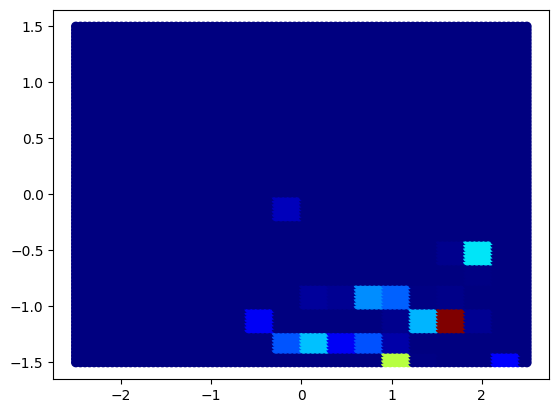

In [22]:
states = np.array(np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-1.5,1.5,100)))
states = np.array(states).reshape(2,-1).T
states = np.array([[states[i,0], states[i,1], 0] for i in range(len(states))])

start = np.array([2, -1, 0])
starts = np.array([start for _ in range(100 * 100)])

r_val = np.exp(np.array(forward_autoregressive_model(starts, states)))
plt.clf()
plt.cla()
plt.scatter(states[:, 0], states[:, 1], c=r_val, cmap=cm.jet)

In [ ]:
r_val = np.array([query(starts[i], states[i]) for i in range(len(starts))])
plt.clf()
plt.cla()
plt.scatter(states[:, 0], states[:, 1], c=r_val, cmap=cm.jet)